## Model discrimination via genetic algorithm

Generating training data...
Generating test data...
Running genetic algorithm optimization...

Generation 0
New best fitness: -2.3373335446370676
Parameters: [0.5231691715891885, 1.6406573157701874, 2.713606688222201, 0.40488023539124496, 2.3283798007980963]
Active terms: ['Monod Growth', 'Non-Competitive Product Inhibition', 'Competitive Inhibition Factor']
Errors by experiment: [0.6159299076014074, 1.213038705799373, 0.02217294843555188, 0.33619198280073526]

Generation 0 summary:
Best fitness: -2.3373335446370676
Current best parameters: [0.5231691715891885, 1.6406573157701874, 2.713606688222201, 0.40488023539124496, 2.3283798007980963]
Current errors by experiment: [0.6159299076014074, 1.213038705799373, 0.02217294843555188, 0.33619198280073526]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9547090316063D+01   r2 =  0.6136365902002D-15

/Users/Laura/repo/rEaCt-Retreat-2025/bio_model.py:283: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y_pred = odeint(



Generation 18
New best fitness: -0.5360911088899778
Parameters: [0.641534593928891, 1.091294007249594, 3.051268884492013, 0.4013907634398278, 2.8874021379226136]
Active terms: ['Monod Growth', 'Competitive Inhibition Factor', 'Substrate Threshold Activation']
Errors by experiment: [0.06534020701440776, 0.24479831588087744, 0.027279610952690114, 0.04867297504200249]

Generation 19
New best fitness: -0.5356174235478386
Parameters: [0.6408032503593727, 1.0909272111034947, 3.0501936892231485, 0.39152010830140416, 2.8708131837276207]
Active terms: ['Monod Growth', 'Competitive Inhibition Factor', 'Substrate Threshold Activation']
Errors by experiment: [0.06890763764417028, 0.23371409258506465, 0.0306348101273101, 0.05236088319129345]

Generation 20
New best fitness: -0.5345263479382399
Parameters: [0.6404387181692472, 1.0915932749175488, 3.0490807989770867, 0.38925196736023043, 2.8804185778940425]
Active terms: ['Monod Growth', 'Competitive Inhibition Factor', 'Substrate Threshold Activati

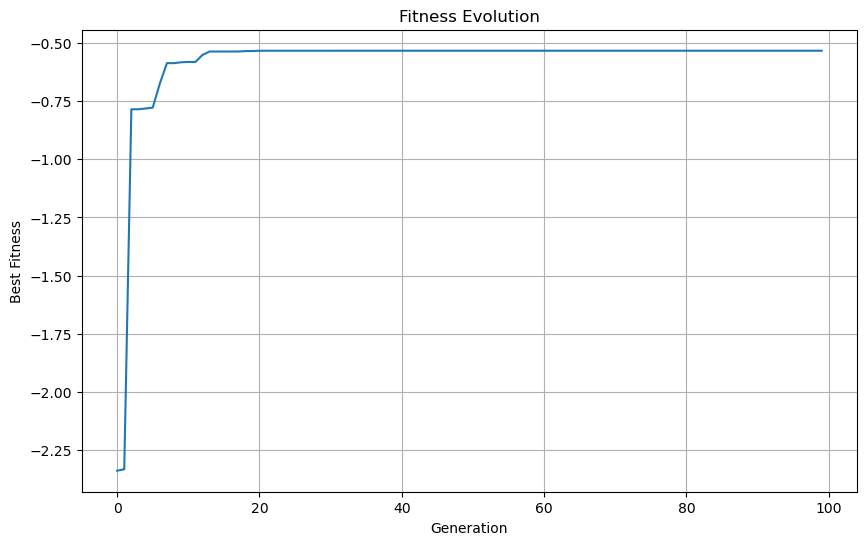

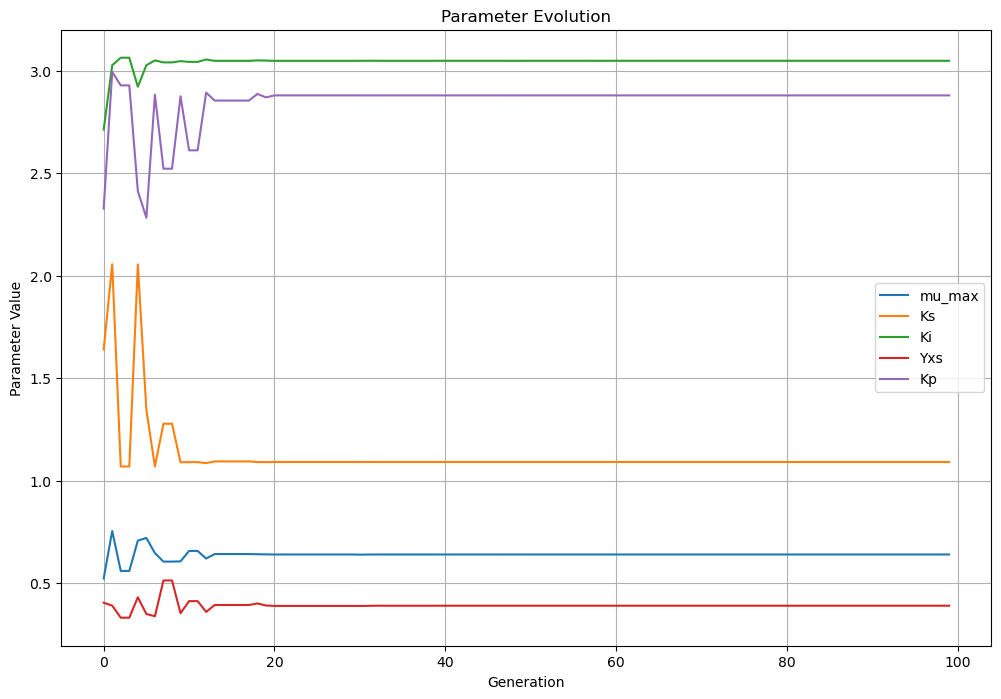


Evaluating solution...

Chosen Terms:
- Monod Growth
- Competitive Inhibition Factor
- Substrate Threshold Activation

Best Parameters:
mu_max=0.6403799990759952, true value:0.5
Ks=1.0915818628507443, true value:2.0
Kp=3.0492721650822276, true value:1.0
Yxs=0.39035831417503636, true value:0.4
Ki=2.8803625331426113, true value:nan

Test Data Performance:
Overall RMSE: 0.7405

RMSE by variable:
biomass: 0.4790
substrate: 1.1225
product: 0.1437
inhibitor: 0.0000


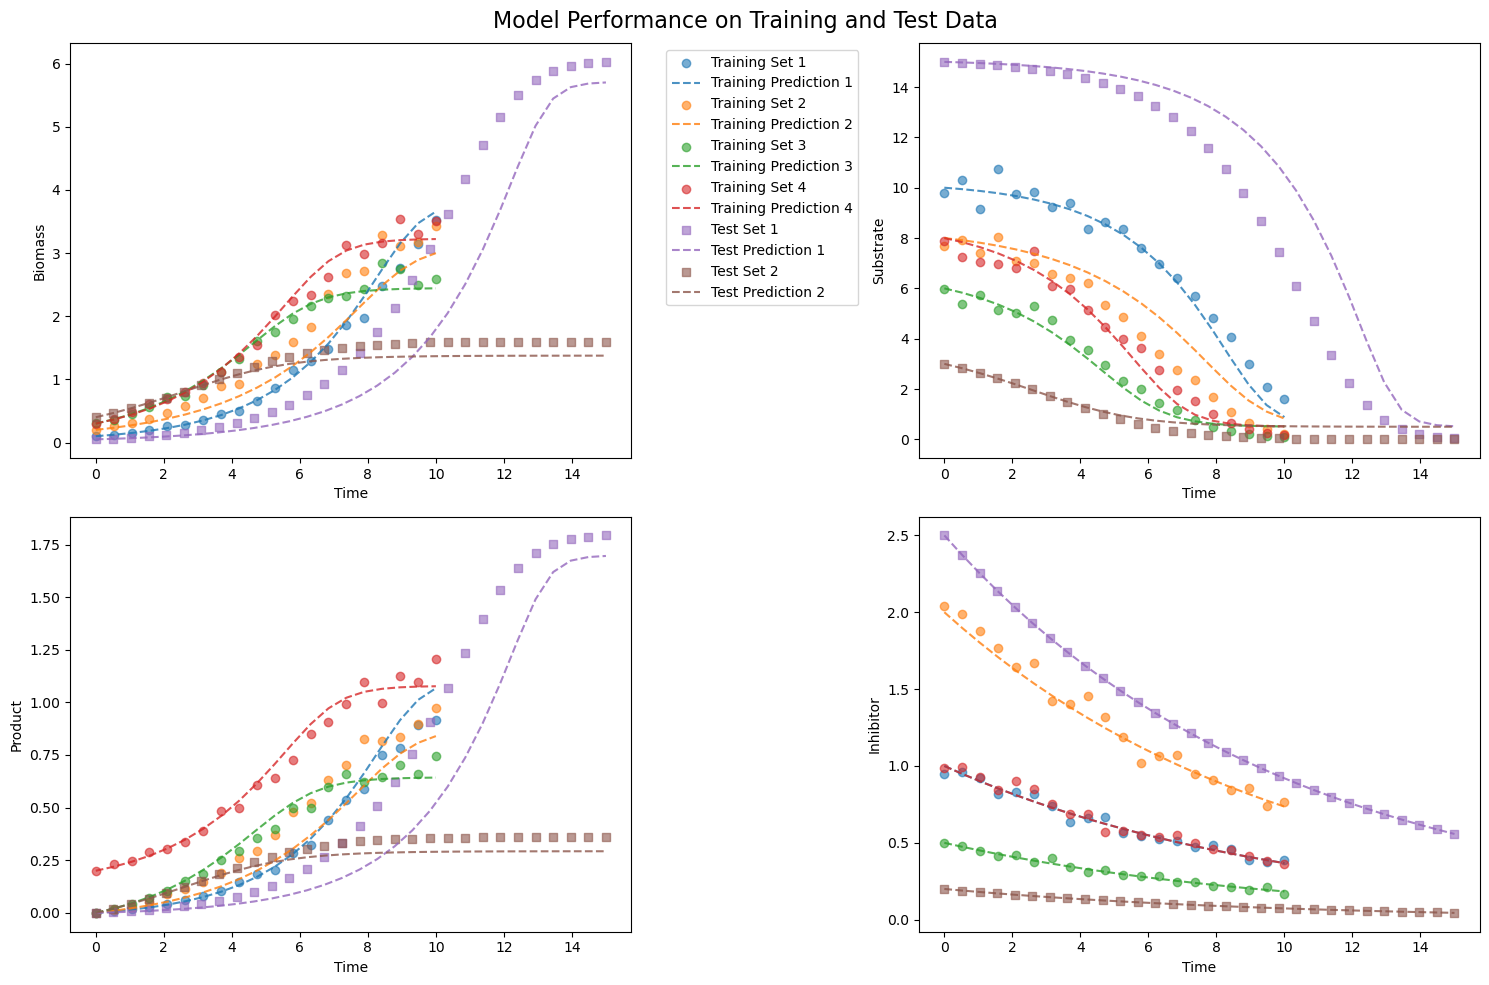

In [1]:
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from bio_model import (
    evaluate_student_solution,
    genetic_algorithm,
    generate_training_data,
    generate_test_data,
    true_model_day2,
    true_model_day3,
    plot_results,
    DEFAULT_PARAMS,
    DAY3_PARAMS,
    TERM_NAMES,
)

# Define initial conditions
initial_conditions = [
    [0.1, 10.0, 0.0, 1.0],  # Low X, high S, medium I
    [0.2, 8.0, 0.0, 2.0],   # Medium X, medium S, high I
    [0.3, 6.0, 0.0, 0.5],   # High X, low S, medium I
    [0.3, 8.0, 0.2, 1.0],   # High X, medium S, high I
]

# Generate and save training data
print("Generating training data...")
train_data  = generate_training_data(
    initial_conditions=initial_conditions,
    true_model=true_model_day2,
)
with open("training_data_day2.pickle", "wb") as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("training_data_day2.pickle", "rb") as handle:
    training_data = pickle.load(handle)

# Generate test data
print("Generating test data...")
test_conditions = [
    [0.05, 15.0, 0.0, 2.5],  # Very low X, very high S
    [0.4, 3.0, 0.0, 0.2],  # Very high X, very low S
]
test_data = generate_test_data(test_conditions=test_conditions, true_model=true_model_day2)

# Run genetic algorithm optimization
print("Running genetic algorithm optimization...")
best_individual = genetic_algorithm(
    training_data,
    population_size=30,
    generations=100
)

# Evaluate solution
print("\nEvaluating solution...")
rmse, variable_rmse, test_predictions = evaluate_student_solution(
    best_individual["mask"],
    best_individual["params"],
    test_data
)

# Print results
print("\nChosen Terms:")
for i, (term, active) in enumerate(zip(TERM_NAMES, best_individual["mask"])):
    if active:
        print(f"- {term}")

print("\nBest Parameters:")
true_values = [0.5, 2.0, 1.0, 0.4, "NaN"]
for (param, true_value), value in zip(
    DEFAULT_PARAMS.items(),
    best_individual["params"],
):
    print(f"{param}={value}, true value:{true_value}")

print("\nTest Data Performance:")
print(f"Overall RMSE: {rmse:.4f}")
print("\nRMSE by variable:")
for var, error in variable_rmse.items():
    print(f"{var}: {error:.4f}")

# Plot results with enhanced visualization
plot_results(training_data, test_data, best_individual, test_predictions)

Generating training data...
Generating test data...
Running genetic algorithm optimization...

Generation 0
New best fitness: -0.36638242113410885
Parameters: [0.15963584619406593, 3.6299636960736312, 0.9510044405991883, 0.307769251083072, 2.8839804994023837]
Active terms: ['Monod Growth', 'Product Inhibition Factor (Competitive)', 'Competitive Inhibition Factor']
Errors by experiment: [0.15168657696774313, 0.05364531605019154, 0.011050528116174149]

Generation 0 summary:
Best fitness: -0.36638242113410885
Current best parameters: [0.15963584619406593, 3.6299636960736312, 0.9510044405991883, 0.307769251083072, 2.8839804994023837]
Current errors by experiment: [0.15168657696774313, 0.05364531605019154, 0.011050528116174149]

Generation 1
New best fitness: -0.34001149305931117
Parameters: [0.6943215363667192, 3.0828096177964115, 2.9828530982698678, 0.3883387191846255, 1.3757765334123453]
Active terms: ['Monod Growth', 'Substrate Inhibition Factor', 'Non-Competitive Product Inhibition']
E

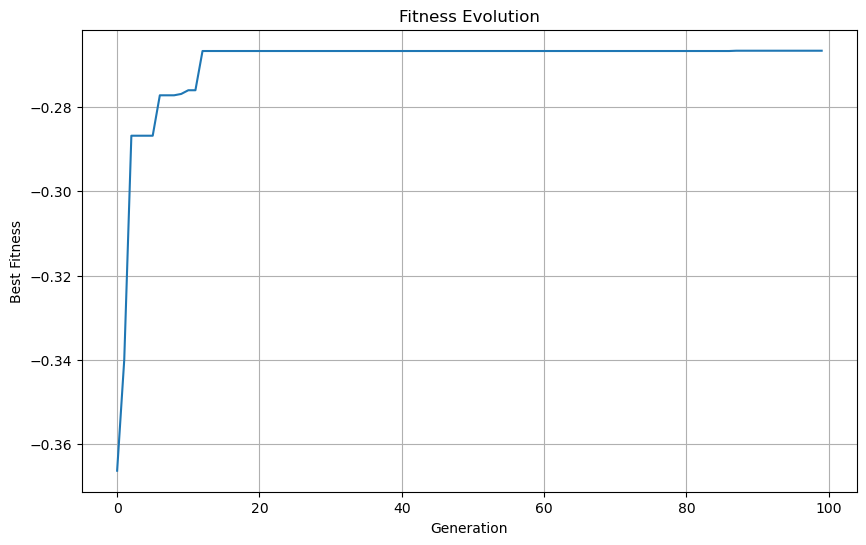

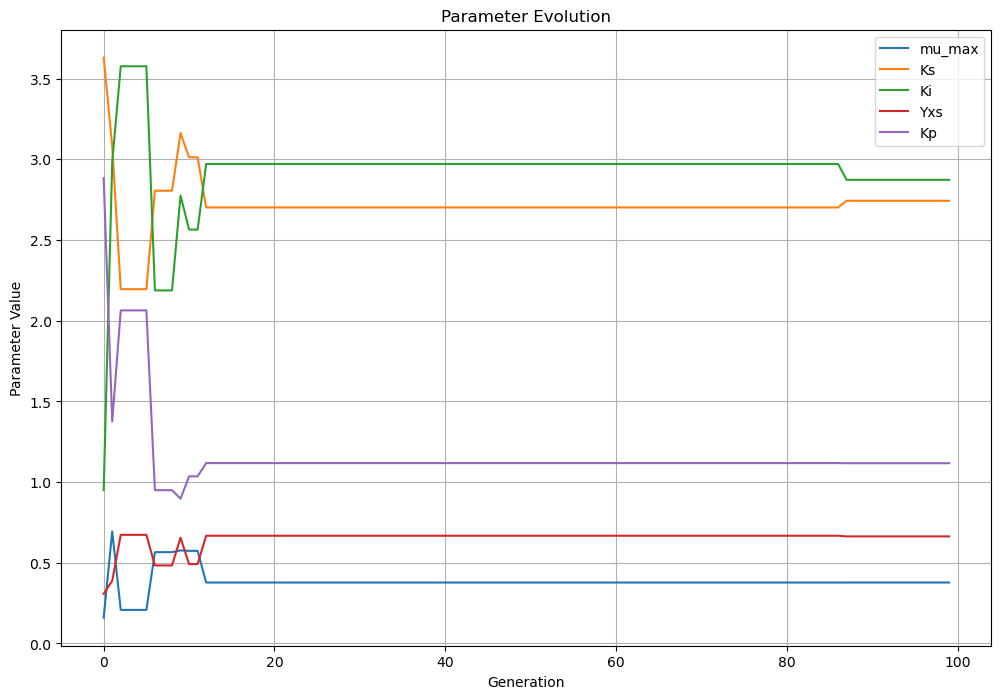


Evaluating solution...

Chosen Terms:
- Double Substrate Limited Factor

Best Parameters:
mu_max=0.3777865206212244, true value:0.8
Ks=2.743448486932607, true value:3.0
Kp=2.873294204484094, true value:2.0
Yxs=0.663549830897546, true value:0.5
Ki=1.1171951667814242, true value:1.5

Test Data Performance:
Overall RMSE: 0.3853

RMSE by variable:
biomass: 0.3312
substrate: 0.5663
product: 0.0994
inhibitor: 0.0000


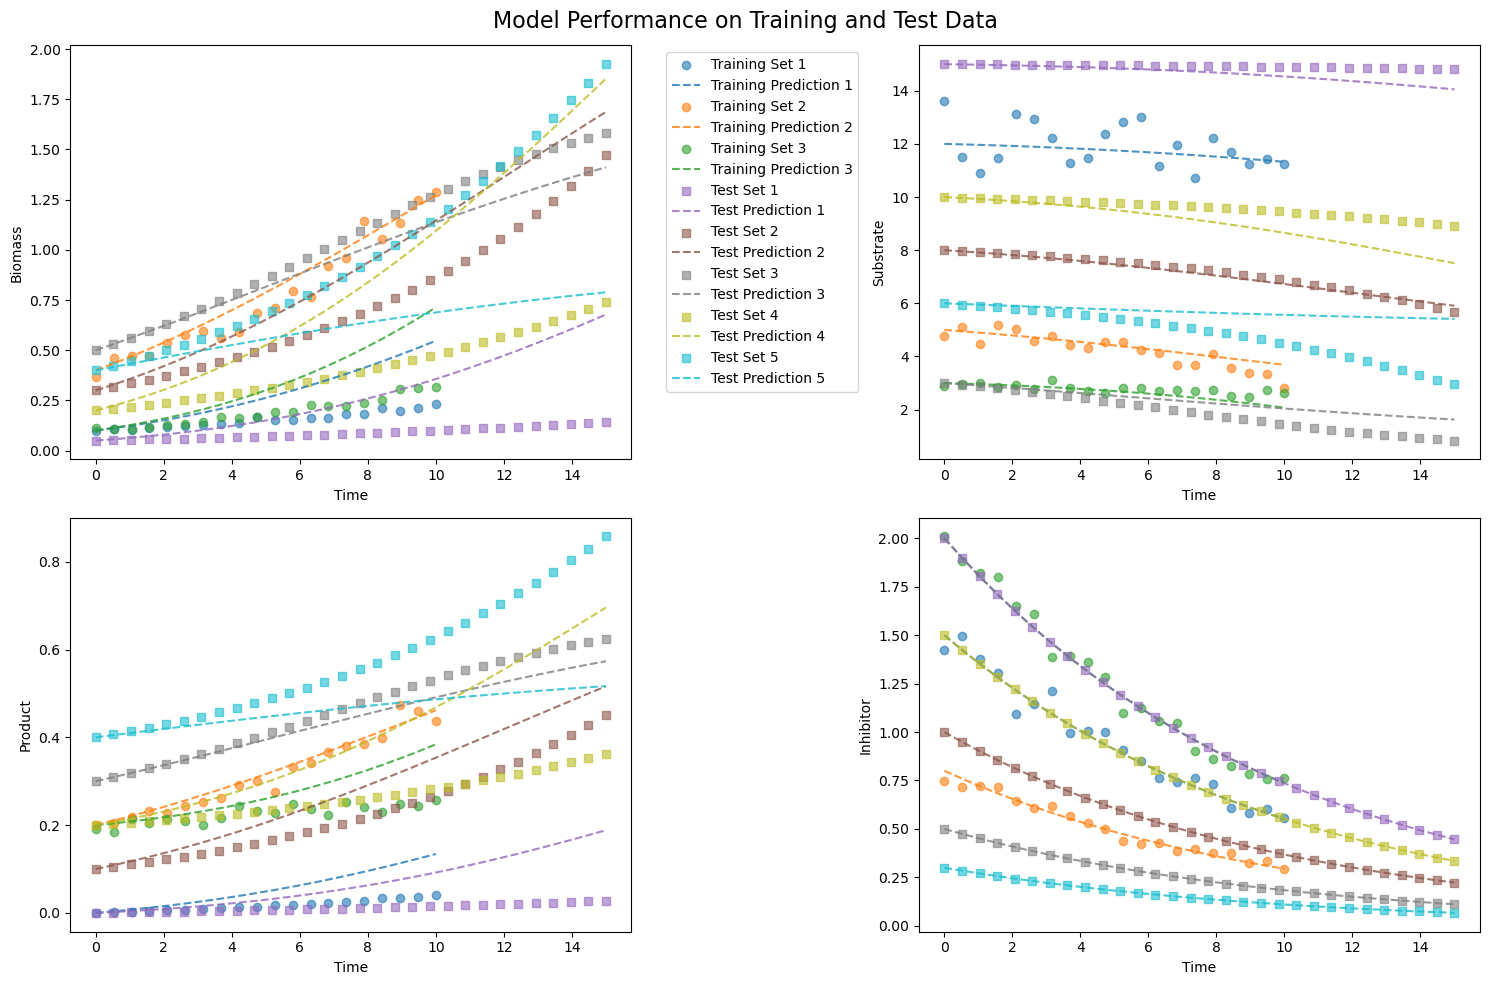

In [2]:
# Generate two training datasets
initial_conditions = [
    [0.1, 12.0, 0.0, 1.5],  # Low X, very high S, medium I
    [0.4, 5.0, 0.2, 0.8],   # High X, medium S, low I
    [0.1, 3.0, 0.2, 2.0],   # Low X, low S, high I
]
    
print("Generating training data...")
train_data = generate_training_data(
    initial_conditions=initial_conditions,
    true_model=true_model_day3,
    )
with open("training_data_day3.pickle", "wb") as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("training_data_day3.pickle", "rb") as handle:
    training_data = pickle.load(handle)

# Test conditions (5 different scenarios)
test_conditions = [
    [0.05, 15.0, 0.0, 2.0],  # Very low X, very high S, high I
    [0.3, 8.0, 0.1, 1.0],    # Medium X, high S, medium I
    [0.5, 3.0, 0.3, 0.5],    # High X, low S, low I
    [0.2, 10.0, 0.2, 1.5],   # Low X, high S, medium I
    [0.4, 6.0, 0.4, 0.3],    # High X, medium S, very low I
]

# Generate test data
print("Generating test data...")
test_data = generate_test_data(test_conditions=test_conditions, true_model=true_model_day3)

# Run genetic algorithm optimization
print("Running genetic algorithm optimization...")
best_individual = genetic_algorithm(
    training_data,
    population_size=30,
    generations=100
)

# Evaluate solution
print("\nEvaluating solution...")
rmse, variable_rmse, test_predictions = evaluate_student_solution(
    best_individual["mask"],
    best_individual["params"],
    test_data
)

# Print results
print("\nChosen Terms:")
for i, (term, active) in enumerate(zip(TERM_NAMES, best_individual["mask"])):
    if active:
        print(f"- {term}")

print("\nBest Parameters:")
for (param, true_value), value in zip(
    DAY3_PARAMS.items(),
    best_individual["params"],
):
    print(f"{param}={value}, true value:{true_value}")

print("\nTest Data Performance:")
print(f"Overall RMSE: {rmse:.4f}")
print("\nRMSE by variable:")
for var, error in variable_rmse.items():
    print(f"{var}: {error:.4f}")

# Plot results with enhanced visualization
plot_results(training_data, test_data, best_individual, test_predictions)